In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow


class Panaroma:
  #horizontal image stitch
    def image_stitch(self, images, lowe_ratio=0.75, max_Threshold=4.0, match_status=False):
        # Detect features and keypoints from SIFT
        (imageB, imageA) = images
        (key_points_A, features_of_A) = self.detect_feature_and_keypoints(imageA)
        (key_points_B, features_of_B) = self.detect_feature_and_keypoints(imageB)

        # Get valid matched points
        Values = self.match_keypoints(key_points_A, key_points_B, features_of_A, features_of_B, lowe_ratio, max_Threshold)
        if Values is None:
            return None

        # Get wrap perspective of image using computed homography
        (matches, Homography, status) = Values
        result_image = self.get_warp_perspective(imageA, imageB, Homography)
        result_image[0:imageB.shape[0], 0:imageB.shape[1]] = imageB

        # Check if keypoint matches should be visualized
        if match_status:
            vis = self.draw_matches(imageA, imageB, key_points_A, key_points_B, matches, status)
            return result_image, vis

        return result_image

    def image_stitch_vertical(self, images, lowe_ratio=0.75, max_Threshold=4.0, match_status=False):
        # Detect features and keypoints from SIFT
        (imageA, imageB) = images
        (key_points_A, features_of_A) = self.detect_feature_and_keypoints(imageA)
        (key_points_B, features_of_B) = self.detect_feature_and_keypoints(imageB)

        # Get valid matched points
        Values = self.match_keypoints(key_points_A, key_points_B, features_of_A, features_of_B, lowe_ratio, max_Threshold)
        if Values is None:
            return None

        # Get wrap perspective of image using computed homography
        (matches, Homography, status) = Values
        result_image = self.get_warp_perspective_vertical(imageA, imageB, Homography)
        result_image[0:imageB.shape[0], 0:imageB.shape[1]] = imageB

        # Check if keypoint matches should be visualized
        if match_status:
            vis = self.draw_matches(imageA, imageB, key_points_A, key_points_B, matches, status)
            return result_image, vis

        return result_image

    def get_warp_perspective(self, imageA, imageB, Homography):
        val = imageA.shape[1] + imageB.shape[1]
        result_image = cv2.warpPerspective(imageA, Homography, (val, max(imageA.shape[0], imageB.shape[0])))
        return result_image

    def get_warp_perspective_vertical(self, imageA, imageB, Homography):
        val = imageA.shape[0] + imageB.shape[0]
        result_image = cv2.warpPerspective(imageA, Homography, (max(imageA.shape[1], imageB.shape[1]), val))
        return result_image



    def detect_feature_and_keypoints(self, image):
        # Detect and extract features from the image
        descriptors = cv2.SIFT_create()
        (keypoints, features) = descriptors.detectAndCompute(image, None)
        keypoints = np.float32([i.pt for i in keypoints])
        return keypoints, features

    def get_all_possible_matches(self, featuresA, featuresB):
        # Compute all matches using Euclidean distance. Opencv provide DescriptorMatcher_create() function for that
        match_instance = cv2.DescriptorMatcher_create("BruteForce")
        All_Matches = match_instance.knnMatch(featuresA, featuresB, 2)
        return All_Matches

    def get_all_valid_matches(self, AllMatches, lowe_ratio):
        # Get all valid matches according to Lowe's concept
        valid_matches = []
        for val in AllMatches:
            if len(val) == 2 and val[0].distance < val[1].distance * lowe_ratio:
                valid_matches.append((val[0].trainIdx, val[0].queryIdx))
        return valid_matches

    def compute_homography(self, pointsA, pointsB, max_Threshold):
        return cv2.findHomography(pointsA, pointsB, cv2.RANSAC, max_Threshold)

    def match_keypoints(self, KeypointsA, KeypointsB, featuresA, featuresB, lowe_ratio, max_Threshold):
        all_matches = self.get_all_possible_matches(featuresA, featuresB)
        valid_matches = self.get_all_valid_matches(all_matches, lowe_ratio)

        if len(valid_matches) <= 4:
            return None

        # Construct the two sets of points
        points_A = np.float32([KeypointsA[i] for (_, i) in valid_matches])
        points_B = np.float32([KeypointsB[i] for (i, _) in valid_matches])
        (homograpgy, status) = self.compute_homography(points_A, points_B, max_Threshold)
        return valid_matches, homograpgy, status

    def get_image_dimension(self, image):
        return image.shape[:2]

    def get_points(self, imageA, imageB):
        (hA, wA) = self.get_image_dimension(imageA)
        (hB, wB) = self.get_image_dimension(imageB)
        vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
        vis[0:hA, 0:wA] = imageA
        vis[0:hB, wA:] = imageB
        return vis

    def draw_matches(self, imageA, imageB, KeypointsA, KeypointsB, matches, status):
        (hA, wA) = self.get_image_dimension(imageA)
        vis = self.get_points(imageA, imageB)

        # Loop over the matches
        for ((trainIdx, queryIdx), s) in zip(matches, status):
            if s == 1:
                ptA = (int(KeypointsA[queryIdx][0]), int(KeypointsA[queryIdx][1]))
                ptB = (int(KeypointsB[trainIdx][0]) + wA, int(KeypointsB[trainIdx][1]))
                cv2.line(vis, ptA, ptB, (255, 10, 10), 1)
        return vis


In [ ]:
#For Horizontal stitching
import imutils
import cv2


no_of_images = int(input("Enter the number of images you want to concatenate: "))
print("Enter the image names with extension in order of left to right in the way you want to concatenate: ")
# like tajm1.jpg, tajm2.jpg, tajm3.jpg .... tajmn.jpg

filename = []
for i in range(no_of_images):
    filename.append(input("Enter the %d image name along with path and extension: " % (i + 1)))

images = []
for i in range(no_of_images):
    images.append(cv2.imread(filename[i]))

# We need to modify the images width and height to keep our aspect ratio same across images
for i in range(no_of_images):
    images[i] = imutils.resize(images[i], width=400)

for i in range(no_of_images):
    images[i] = imutils.resize(images[i], height=400)


panorama = Panaroma()
if no_of_images == 2:
    (result, matched_points) = panorama.image_stitch([images[0], images[1]], match_status=True)
else:
    (result, matched_points) = panorama.image_stitch([images[no_of_images - 2], images[no_of_images - 1]], match_status=True)
    for i in range(no_of_images - 2):
        (result, matched_points) = panorama.image_stitch([images[no_of_images - i - 3], result], match_status=True)

# show input images
# for i in range(no_of_images):
#     cv2.imshow("Image {k}".format(k=i + 1), images[i])

# show the panorama image and valid matched points




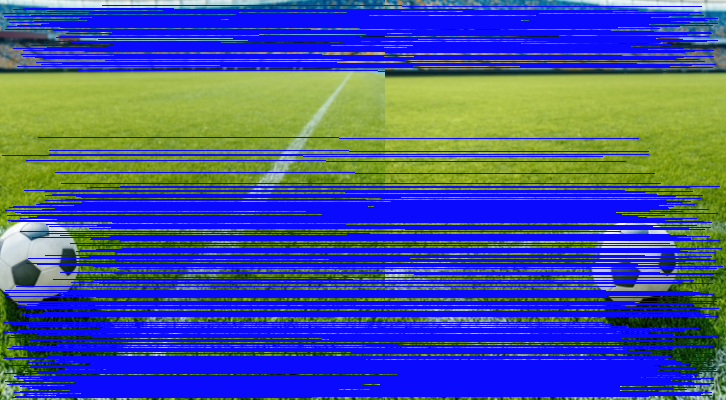

In [ ]:
cv2_imshow(matched_points)

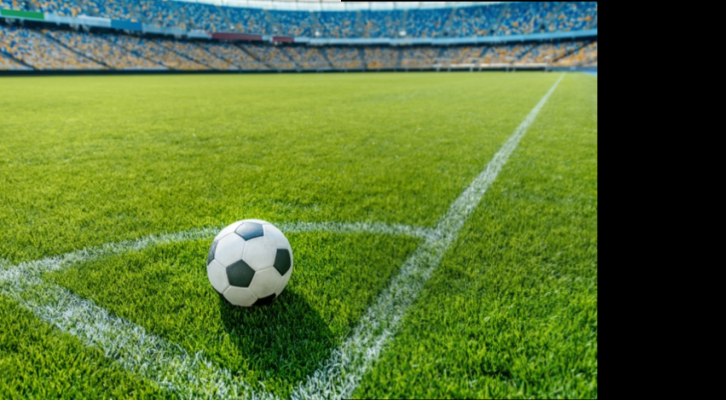

In [ ]:
cv2_imshow(result)

In [ ]:
#Now apply stitching over vertical feature matching
import imutils
import cv2


no_of_images = int(input("Enter the number of images you want to concatenate: "))
print("Enter the image names with extension in order of left to right in the way you want to concatenate: ")
# like tajm1.jpg, tajm2.jpg, tajm3.jpg .... tajmn.jpg

filename = []
for i in range(no_of_images):
    filename.append(input("Enter the %d image name along with path and extension: " % (i + 1)))

images = []
for i in range(no_of_images):
    images.append(cv2.imread(filename[i]))

# We need to modify the images width and height to keep our aspect ratio same across images
for i in range(no_of_images):
    images[i] = imutils.resize(images[i], width=400)

for i in range(no_of_images):
    images[i] = imutils.resize(images[i], height=400)


panorama = Panaroma()
if no_of_images == 2:
    (result, matched_points) = panorama.image_stitch_vertical([images[0], images[1]], match_status=True)
else:
    (result, matched_points) = panorama.image_stitch_vertical([images[no_of_images - 2], images[no_of_images - 1]], match_status=True)
    for i in range(no_of_images - 2):
        (result, matched_points) = panorama.image_stitch_vertical([images[no_of_images - i - 3], result], match_status=True)


Enter the number of images you want to concatenate: 2
Enter the image names with extension in order of left to right in the way you want to concatenate: 
Enter the 1 image name along with path and extension: /content/Football_Ver1.jpeg
Enter the 2 image name along with path and extension: /content/Football_Ver2.jpeg


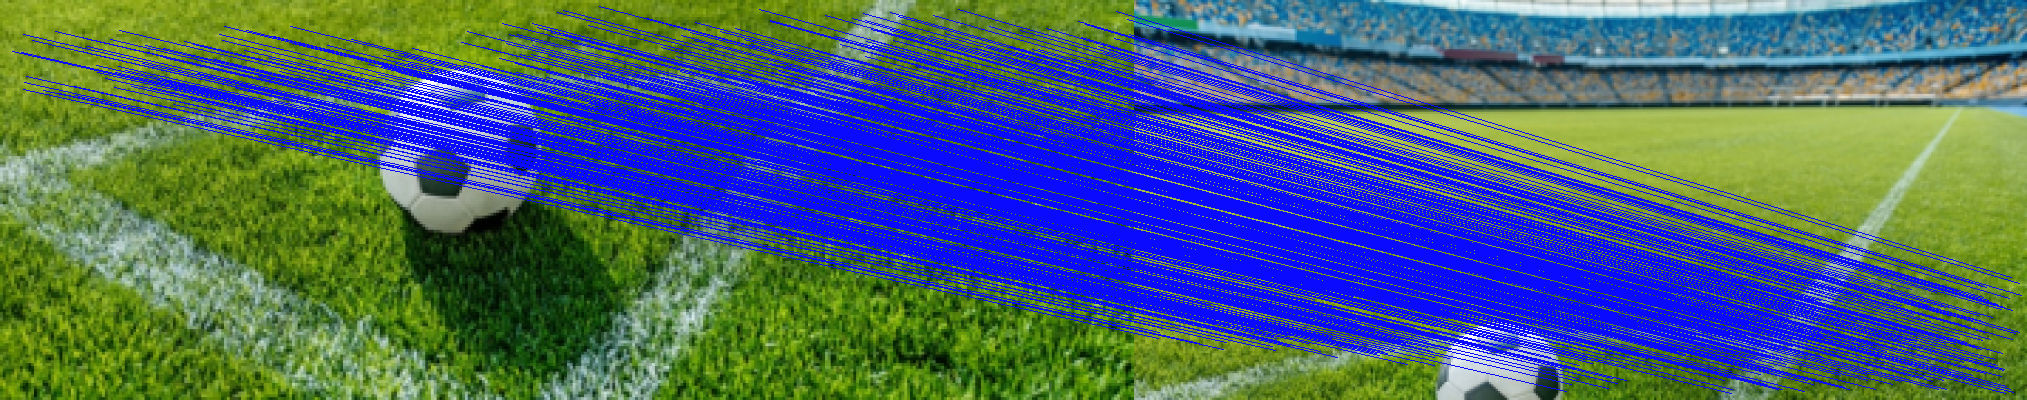

In [ ]:
cv2_imshow(matched_points)

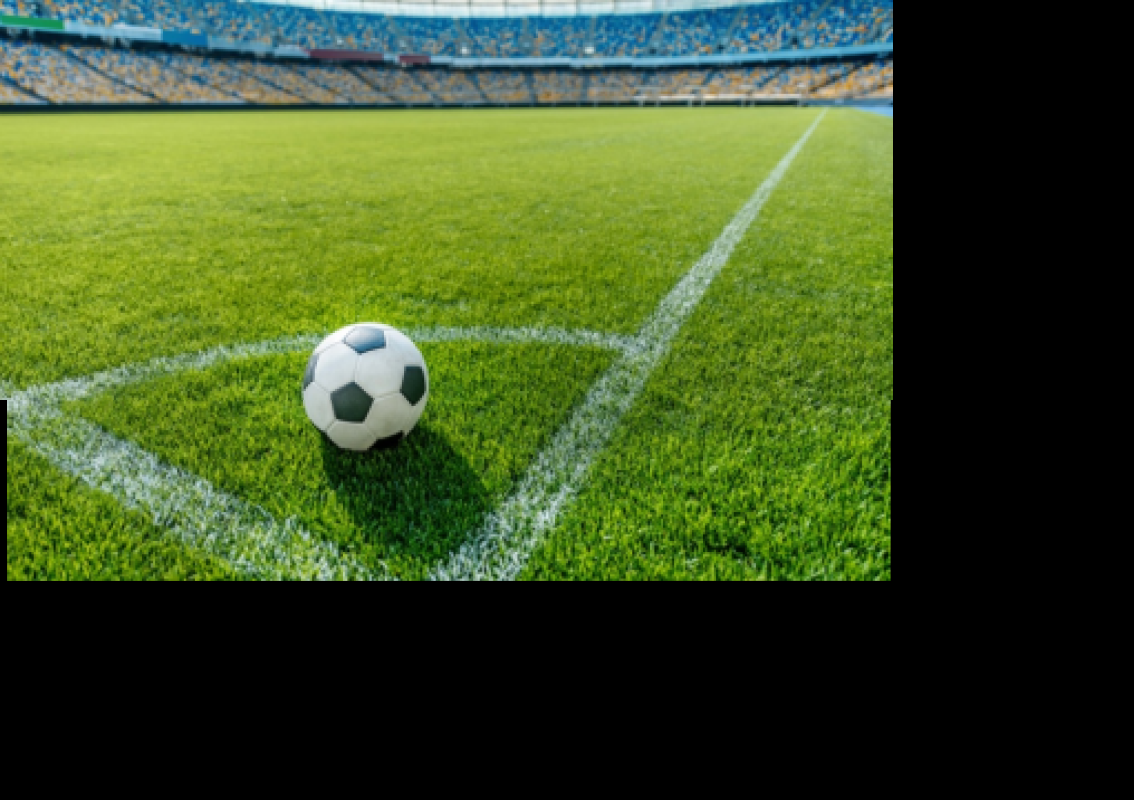

In [ ]:
cv2_imshow(result)

Video Stitching:


In [ ]:
import cv2
import os




def convert_video_to_frames(video_path, output_folder):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Open the video file
    cap = cv2.VideoCapture(video_path)
    frame_count = 0

    # Read frames from the video and save them as images
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        cv2.imwrite(os.path.join(output_folder, f"frame{frame_count:04d}.jpg"), frame)
        frame_count += 1

    cap.release()

    print(f"Frames extracted from {video_path}")

def stitch_video_frames(input_folder1, input_folder2, output_folder, panorama):
    frames_folder1 = [cv2.imread(os.path.join(input_folder1, frame)) for frame in sorted(os.listdir(input_folder1))]
    frames_folder2 = [cv2.imread(os.path.join(input_folder2, frame)) for frame in sorted(os.listdir(input_folder2))]
    stitched_frames = []

    # Iterate through frames and stitch them
    for frame1, frame2 in zip(frames_folder1, frames_folder2):
        stitched_frame = panorama.image_stitch([frame1, frame2])
        stitched_frames.append(stitched_frame)

    # Save stitched frames as images
    for i, frame in enumerate(stitched_frames):
        cv2.imwrite(os.path.join(output_folder, f"stitched_frame{i:04d}.jpg"), frame)

    print("Frames stitched successfully")


def compile_frames_to_video(input_folder, output_video_path):
    frame_files = [os.path.join(input_folder, frame) for frame in os.listdir(input_folder)]

    # Sort frames based on their filenames
    frame_files.sort()

    # Read the first frame to get its dimensions
    frame = cv2.imread(frame_files[0])
    height, width, _ = frame.shape

    # Initialize video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, 30.0, (width, height))

    # Write frames to the output video
    for frame_file in frame_files:
        frame = cv2.imread(frame_file)
        out.write(frame)

    out.release()
    print("Video compiled successfully")


panaroma = Panaroma()
# Define input and output paths
video1_path = "h1.mp4"
video2_path = "h2.mp4"
output_folder1 = "frames1"
output_folder2 = "frames2"
stitched_frames_folder = "stitch"
output_video_path = "output_video5.mp4"

# Convert videos to frames
convert_video_to_frames(video1_path, output_folder1)
convert_video_to_frames(video2_path, output_folder2)

# Stitch frames
stitch_video_frames(output_folder1,output_folder2,stitched_frames_folder,panaroma)

# Compile stitched frames into a video
compile_frames_to_video(stitched_frames_folder, output_video_path)
